In [35]:
import os 
import sys 
sys.path.append("../training")
import pickle

from save_data import process_data

import hls4ml 
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.losses import CategoricalCrossentropy

from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
from tensorflow_model_optimization.sparsity.keras import strip_pruning
import tensorflow_model_optimization as tfmot

from qkeras.qlayers import QDense, QActivation
from qkeras import QBatchNormalization
from qkeras.quantizers import quantized_bits, quantized_relu
from qkeras.utils import _add_supported_quantized_objects
from tensorflow.keras.models import load_model
from qkeras.utils import _add_supported_quantized_objects

os.environ['XILINX_VIVADO'] = "/data/Xilinx/Vivado/2020.1/"
os.environ['PATH'] = os.environ['XILINX_VIVADO'] + '/bin:' + os.environ['PATH']

## Setup data

In [3]:
def one_hot_encode(data):
    y_encoded = np.zeros([data.shape[0],2], dtype=np.int32)
    for idx, x in enumerate(data):
        if x == 1:
            y_encoded[idx][1] = 1
        else:
            y_encoded[idx][0] = 1
    return y_encoded

In [34]:
START_WINDOW = 0
END_WINDOW = 770
DATA_DIR = "../data"

# convert raw ADC data into npy files 
if os.path.exists(f"{DATA_DIR}/X_train.npy") == False:
    process_data(
        start_window=START_WINDOW, 
        end_window=END_WINDOW, 
        data_dir=DATA_DIR
    )

In [5]:
# load data
X_train_val = np.load(os.path.join(DATA_DIR, 'X_train.npy'))
X_test = np.load(os.path.join(DATA_DIR, 'X_test.npy'))    
y_train_val = np.load(os.path.join(DATA_DIR, 'y_train.npy'))
y_test = np.load(os.path.join(DATA_DIR, 'y_test.npy'))

y_train_val = one_hot_encode(y_train_val)
y_test = one_hot_encode(y_test)

print("Training:")
print("\tSize:", len(X_train_val))
print("\tSample Shape:", len(X_train_val[0]))
print("\tMean:", X_train_val.mean())
print("\tStd. Dev.:", X_train_val.std())

print("Testing:")
print("\tSize:", len(X_test))
print("\tSample Shape:", len(X_test[0]))
print("\tSample Shape:", X_test.mean())
print("\tStd. Dev.:", X_test.std())

Training:
	Size: 99000
	Sample Shape: 1540
	Mean: -59.46036271153089
	Std. Dev.: 1759.24042942374
Testing:
	Size: 11000
	Sample Shape: 1540
	Sample Shape: -58.52290962219599
	Std. Dev.: 1761.6940578897895


## Training

In [6]:
INIT_LEARNING_RATE = 1e-2
VALIDATION_SPLIT = 0.3
BATCH_SIZE = 12800
EPOCHS = 50
CHECKPOINT_FILENAME = "qmodel.h5"
INPUT_SHAPE = (len(X_train_val[0]),)

In [7]:
model = Sequential()
model.add(QDense(2, input_shape=(1540,), name='fc1', kernel_quantizer=quantized_bits(6,0,alpha=1), bias_quantizer=quantized_bits(6,0,alpha=1),))
model.add(BatchNormalization())

pruning_params = {"pruning_schedule": pruning_schedule.ConstantSparsity(0.70, begin_step=200, frequency=100)}
pruning_params = {'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50, final_sparsity=0.80, begin_step=200, end_step=1000)}
model = prune.prune_low_magnitude(model, **pruning_params)

2024-02-03 17:57:38.082077: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-02-03 17:57:38.082106: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2024-02-03 17:57:38.082131: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (correlator4.fnal.gov): /proc/driver/nvidia/version does not exist
2024-02-03 17:57:38.082361: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [8]:
print('=============================Model Summary=============================')
print(model.summary())
print('=======================================================================')

=============================Model Summary=============================
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_fc1 (Pr  (None, 2)                6164      
 uneLowMagnitude)                                                
                                                                 
 prune_low_magnitude_batch_n  (None, 2)                9         
 ormalization (PruneLowMagni                                     
 tude)                                                           
                                                                 
Total params: 6,173
Trainable params: 3,086
Non-trainable params: 3,087
_________________________________________________________________
None


In [9]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    INIT_LEARNING_RATE,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True
)

callbacks = [
        ModelCheckpoint(
        CHECKPOINT_FILENAME,
        monitor="val_loss",
        verbose=0,
        save_best_only=True,
        save_weights_only=False,
        save_freq="epoch",
    ),
    ReduceLROnPlateau(patience=75, min_delta=1**-6),
    pruning_callbacks.UpdatePruningStep(),
]


In [10]:
opt = Adam(learning_rate=INIT_LEARNING_RATE)
model.compile(
    optimizer=opt, 
    # loss=tf.keras.losses.BinaryCrossentropy(),
    loss=CategoricalCrossentropy(from_logits=True), 
    metrics=['accuracy']
)

history = model.fit(
    X_train_val, 
    y_train_val, 
    batch_size=BATCH_SIZE,
    epochs=EPOCHS, 
    validation_split=VALIDATION_SPLIT, 
    shuffle=True, 
    callbacks=callbacks
)

Epoch 1/50
6/6 [==============================] - 2s 119ms/step - loss: 0.4041 - accuracy: 0.8470 - val_loss: 1.3608 - val_accuracy: 0.6991 - lr: 0.0100
Epoch 2/50
6/6 [==============================] - 0s 35ms/step - loss: 0.2311 - accuracy: 0.9558 - val_loss: 0.8749 - val_accuracy: 0.7158 - lr: 0.0100
Epoch 3/50
6/6 [==============================] - 0s 31ms/step - loss: 0.2214 - accuracy: 0.9566 - val_loss: 0.6643 - val_accuracy: 0.7445 - lr: 0.0100
Epoch 4/50
6/6 [==============================] - 0s 34ms/step - loss: 0.2135 - accuracy: 0.9569 - val_loss: 0.5436 - val_accuracy: 0.7745 - lr: 0.0100
Epoch 5/50
6/6 [==============================] - 0s 31ms/step - loss: 0.2060 - accuracy: 0.9571 - val_loss: 0.4650 - val_accuracy: 0.8021 - lr: 0.0100
Epoch 6/50
6/6 [==============================] - 0s 33ms/step - loss: 0.1996 - accuracy: 0.9575 - val_loss: 0.4073 - val_accuracy: 0.8279 - lr: 0.0100
Epoch 7/50
6/6 [==============================] - 0s 34ms/step - loss: 0.1941 - accurac

In [11]:
model = strip_pruning(model)
model.save(CHECKPOINT_FILENAME)

print(f'Saved checkpoint to: {CHECKPOINT_FILENAME}')
history_file = CHECKPOINT_FILENAME.replace(".h5", "-history.pkl")
print(f'Saving history to: {history_file}')
with open(history_file, 'wb') as file_pi:
    pickle.dump(history.history, file_pi)


Saved checkpoint to: qmodel.h5
Saving history to: qmodel-history.pkl


In [12]:
co = {}
_add_supported_quantized_objects(co)
model = load_model(CHECKPOINT_FILENAME, custom_objects=co, compile=False)
y_pred = model.predict(X_test)
print("Keras  Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))))

344/344 [==============================] - 0s 873us/step
Keras  Accuracy: 0.9546363636363636


Number of layers: 2


% of zeros = 0.599025974025974
% of zeros = 0.0


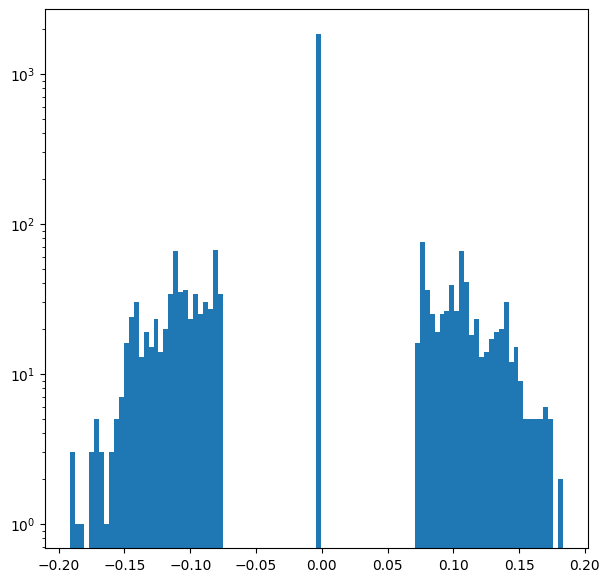

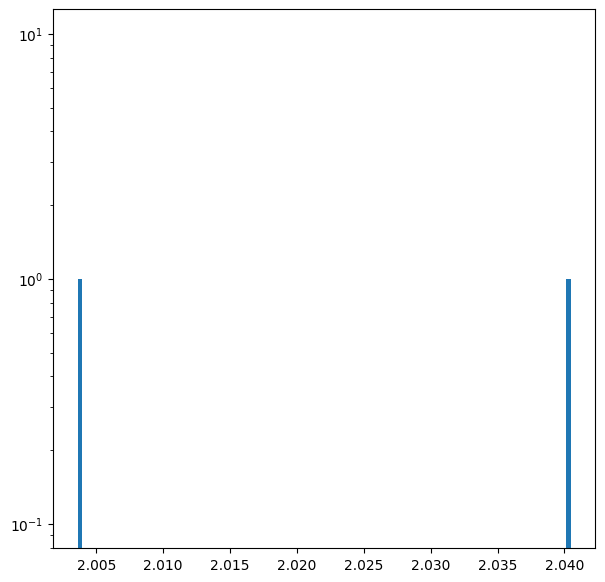

In [14]:
num_layers = len(model.layers)
print(f'Number of layers: {num_layers}')


for idx in range(num_layers):
    w = model.layers[idx].weights[0].numpy()
    h, b = np.histogram(w, bins=100)

    # plot weight distribution
    plt.figure(figsize=(7, 7))
    plt.bar(b[:-1], h, width=b[1] - b[0])
    plt.semilogy()
    plt.savefig(f'model-dist-idx{idx}.png')

    print('% of zeros = {}'.format(np.sum(w == 0) / np.size(w)))

## Buidling HLS model 

In [15]:
sys.path.append("../utils")
from config import print_dict

from tensorflow.keras.models import load_model
from qkeras.utils import _add_supported_quantized_objects

In [16]:
# Load model 
co = {}
_add_supported_quantized_objects(co)
model = load_model(CHECKPOINT_FILENAME, custom_objects=co, compile=False)
y_pred = model.predict(X_test)

# Evalulate 
y_keras = model.predict(X_test)
print(f'Model acc: {accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))}')
print(model.summary()) 

344/344 [==============================] - 0s 839us/step
Model acc: 0.9546363636363636
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fc1 (QDense)                (None, 2)                 3082      
                                                                 
 batch_normalization (BatchN  (None, 2)                8         
 ormalization)                                                   
                                                                 
Total params: 3,090
Trainable params: 3,086
Non-trainable params: 4
_________________________________________________________________
None


In [17]:
# Create HLS configuration 
HLSConfig = {}
HLSConfig['Model'] = {}
HLSConfig['Model']['Precision'] = 'ap_fixed<16,6>'  # Default precision
HLSConfig['Model']['ReuseFactor'] = 1  # fully parallelized 

HLSConfig['LayerName'] = {}
for layer in ['fc1_input', 'fc1', 'fc1_linear', 'batch_normalization']:
    HLSConfig['LayerName'][layer] = {}
    HLSConfig['LayerName'][layer]['Precision'] = {}
    HLSConfig['LayerName'][layer]['Trace'] = True

# Input - ZCU216 uses 14-bit ADCS 
HLSConfig['LayerName']['fc1_input']['Precision'] = 'ap_fixed<14,14>' 
# Fc
HLSConfig['LayerName']['fc1']['Precision']['result'] = 'ap_fixed<18,18>'
HLSConfig['LayerName']['fc1']['accum_t'] = 'ap_fixed<18,18>'
# Fc Linear
HLSConfig['LayerName']['fc1_linear']['Precision']['result'] = 'ap_fixed<18,18>'
# Batchnormalization
HLSConfig['LayerName']['batch_normalization']['Precision']['scale'] = 'ap_fixed<20,3>'
HLSConfig['LayerName']['batch_normalization']['Precision']['bias'] = 'ap_fixed<20,3>'
HLSConfig['LayerName']['batch_normalization']['Precision']['result'] = 'ap_fixed<16,6>'

print_dict(HLSConfig)

Model
  Precision:         ap_fixed<16,6>
  ReuseFactor:       1
LayerName
  fc1_input
    Precision:       ap_fixed<14,14>
    Trace:           True
  fc1
    Precision
      result:        ap_fixed<18,18>
    Trace:           True
    accum_t:         ap_fixed<18,18>
  fc1_linear
    Precision
      result:        ap_fixed<18,18>
    Trace:           True
  batch_normalization
    Precision
      scale:         ap_fixed<20,3>
      bias:          ap_fixed<20,3>
      result:        ap_fixed<16,6>
    Trace:           True


In [18]:
OutputDir = 'hls4ml_prj/'
XilinxPart = 'xczu49dr-ffvf1760-2-e'
IOType = 'io_parallel'
ClockPeriod = 3.225  # 3.225ns (307.2 MHz)
HLSFig = OutputDir+'model.png'

hls_model = hls4ml.converters.convert_from_keras_model(
    model=model,
    hls_config=HLSConfig,
    output_dir=OutputDir,
    part=XilinxPart,
    io_type=IOType,
    clock_period=ClockPeriod,
)

Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 1540]], output shape: [None, 1540]
Layer name: fc1, layer type: QDense, input shapes: [[None, 1540]], output shape: [None, 2]
Layer name: batch_normalization, layer type: BatchNormalization, input shapes: [[None, 2]], output shape: [None, 2]
Creating HLS model


In [19]:
print(f"Creating hls4ml project directory {OutputDir}")
hls_model.compile()

# visualize model
hls4ml.utils.plot_model(
    hls_model, show_shapes=True, show_precision=True, to_file=HLSFig
)

Creating hls4ml project directory hls4ml_prj/
Writing HLS project


Done


In [20]:
# Trace output 
y_hls = hls_model.predict(np.ascontiguousarray(X_test.astype(np.float32))) 
_, hls_trace = hls_model.trace(np.ascontiguousarray(X_test.astype(np.float32))) 

keras_trace = hls4ml.model.profiling.get_ymodel_keras(model, X_test.astype(np.float32)) 

Recompiling myproject with tracing
Writing HLS project


Done
344/344 [==============================] - 0s 1ms/step
Done taking outputs for Keras model.


In [21]:
y_hls = np.argmax(y_hls, axis=1)

print(f'Keras Acc: {accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))*100}%')
print(f'HLS Acc: {accuracy_score(np.argmax(y_test, axis=1), y_hls)*100}%')
print(f'CKA: {accuracy_score(np.argmax(y_keras, axis=1), y_hls)*100}%')

Keras Acc: 95.46363636363637%
HLS Acc: 95.38181818181818%
CKA: 99.79090909090908%


In [22]:
print(f'HLS Keys: {hls_trace.keys()}')
print(f'Keras Keys: {keras_trace.keys()}')

HLS Keys: dict_keys(['fc1', 'batch_normalization'])
Keras Keys: dict_keys(['fc1', 'batch_normalization'])


fc1 		 289.50885


hls/keras min: -48808.0/-48534.46875
hls/keras max: 51371.0/51662.03125
batch_normalization 		 0.064021505
hls/keras min: -4.0810546875/-4.159836292266846
hls/keras max: 3.99609375/4.071556091308594


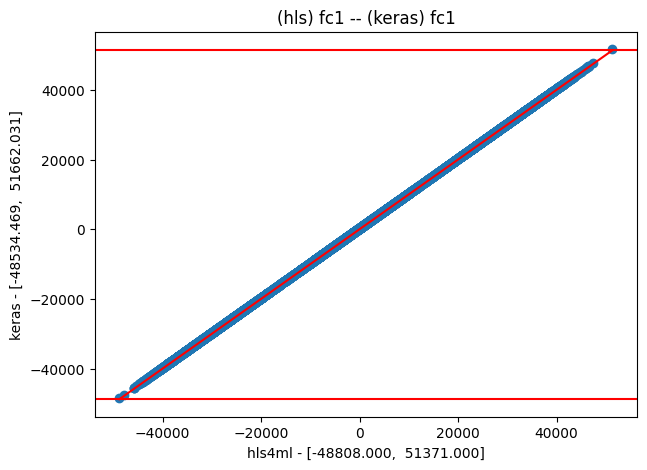

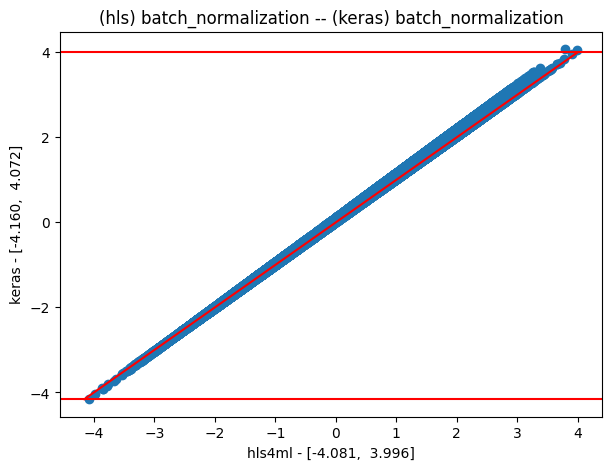

In [23]:
layers = ['fc1', 'batch_normalization']

for idx, layer in enumerate(layers):
    keras_layer, hls_layer = keras_trace[layer], hls_trace[layer]
    try:
        diff = np.average(np.abs(keras_layer - hls_layer ))
        print(f'{layer}', '\t\t', diff)
        
        plt.figure(figsize=(7, 5))

        plt.scatter(hls_layer.flatten(), keras_layer.flatten())
        min_x = min(keras_layer.min(), hls_layer.min())
        max_x = min(keras_layer.max(), hls_layer.max())

        onnx_min, onnx_max = keras_layer.flatten().min(), keras_layer.flatten().max()
        hls_min, hls_max = hls_layer.flatten().min(), hls_layer.flatten().max()
        
        print(f'hls/keras min: {hls_min}/{onnx_min}')
        print(f'hls/keras max: {hls_max}/{onnx_max}')
        
        plt.plot([min_x, max_x], [min_x, max_x], c='red')
        plt.axhline(min_x, c='red')
        plt.axhline(max_x, c='red')

        plt.title(f'(hls) {layer} -- (keras) {layer}')
        plt.xlabel(f'hls4ml - [{hls_min:.3f},  {hls_max:.3f}]')
        plt.ylabel(f'keras - [{onnx_min:.3f},  {onnx_max:.3f}]')
        plt.yscale('linear')
    except Exception as e:
        print(e)


## Synthesize model 

In [28]:
hls_model.build(
    csim=False,
    synth=True,
    cosim=False,
    export=True,
    vsynth=False,
)


****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2020.1 (64-bit)
  **** SW Build 2902540 on Wed May 27 19:54:35 MDT 2020
  **** IP Build 2902112 on Wed May 27 22:43:36 MDT 2020
    ** Copyright 1986-2020 Xilinx, Inc. All Rights Reserved.

source /data/Xilinx/Vivado/2020.1/scripts/vivado_hls/hls.tcl -notrace
INFO: Applying HLS Y2K22 patch v1.2 for IP revision
INFO: [HLS 200-10] Running '/data/Xilinx/Vivado/2020.1/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'jcampos' on host 'correlator4.fnal.gov' (Linux_x86_64 version 3.10.0-1160.105.1.el7.x86_64) on Sat Feb 03 18:01:50 CST 2024
INFO: [HLS 200-10] On os "Scientific Linux release 7.9 (Nitrogen)"
INFO: [HLS 200-10] In directory '/data/jcampos/projects/ml-quantum-readout/notebooks/hls4ml_prj'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-10] Opening project '/data/jcampos/projects/ml-quantum-readout/notebooks/hls4ml_prj/myproject_prj'.
INFO: [HLS 200-10] Adding design file 'firmware/myproject.cp

{}

In [25]:
hls4ml.report.read_vivado_report('hls4ml_prj/hls4ml_prj')

Path hls4ml_prj/hls4ml_prj does not exist. Exiting.
